In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [3]:
#Load & Preprocess UNSW-NB15_4 Dataset
df = pd.read_csv('C:/Users/Artophilic/Datascience Bootcamp/Network_research/Dataset/UNSW-NB15_4.csv')

In [4]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
df = df.drop(columns=["proto","service","state","attack_cat"])

In [6]:
#Splitting the data into independent and dependent data

X = df.drop(columns=['label']).copy()
X.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,1,0.121478,6,4,258,172,74.087490,252,254,14158.942380,...,1,1,1,1,0,0,0,1,1,0
1,2,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,...,1,1,1,2,0,0,0,1,6,0
2,3,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,...,2,1,1,3,0,0,0,2,6,0
3,4,1.681642,12,12,628,770,13.677108,62,252,2740.178955,...,2,1,1,3,1,1,0,2,1,0
4,5,0.449454,10,6,534,268,33.373826,254,252,8561.499023,...,2,2,1,40,0,0,0,2,39,0


In [7]:
y = df['label'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [8]:
#Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

In [9]:
# Convert to binary labels: 1 for normal, -1 for anomaly
y = y.replace({0: 1, 1: -1})

In [10]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
''' 
convert numerical features into binary values (e.g., using thresholding or binning) 
to simulate decisions (as ZDDs are boolean-based).
'''
from sklearn.preprocessing import KBinsDiscretizer

# Use KBinsDiscretizer to bin continuous values
binner = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')  # or 'quantile'
X_train_bin = binner.fit_transform(X_train)
X_test_bin = binner.transform(X_test)

X_train_bin = X_train_bin.astype(int)
X_test_bin = X_test_bin.astype(int)

In [12]:
#Defining number of batches to pu forward in partial fitting
n_chunks = 50
chunk_size = len(X_train_bin) // n_chunks 

In [13]:
#Breaking into chunks
X_chunks = [X_train_bin[i:i + chunk_size] for i in range(0, len(X_train_bin), chunk_size)]
y_chunks = [y_train.values[i:i + chunk_size] for i in range(0, len(X_train_bin), chunk_size)]

In [14]:
#Creating model
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [15]:
# Initialize model with a loss for classification
online_model = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, random_state=42)

In [16]:
#Plotting estimate curve
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [18]:
train_sizes, train_scores, test_scores = learning_curve(
    online_model,
    X_train_bin,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    shuffle=True,
    random_state=42
)

c:\Users\Artophilic\anaconda3\envs\netvenv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Artophilic\anaconda3\envs\netvenv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Artophilic\anaconda3\envs\netvenv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Artophilic\anaconda3\envs\netvenv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  war

In [19]:
# Calculate mean and std for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

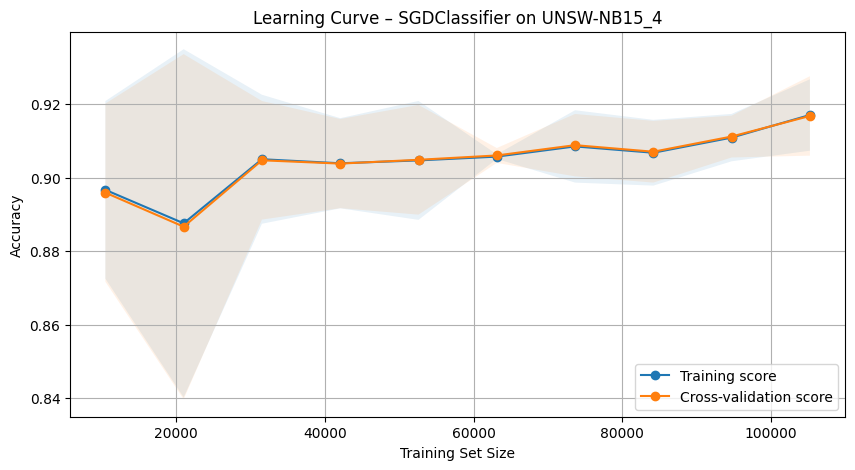

In [ ]:
# Plotting the curve
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve – SGDClassifier on UNSW-NB15_4")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


''' 
Learning Curve – SGDClassifier on UNSW-NB15_4
The learning curve reveals how the model's accuracy evolves with increasing training set sizes. We observe:
Stability and generalization: Both training and cross-validation scores converge around 91%–92% accuracy as more data is introduced.
Bias-variance insight: The gap between training and validation curves is minimal, suggesting low variance and good generalization.
Confidence in scalability: This implies the SGDClassifier adapts well even with incremental data—ideal for online learning or streaming scenarios.'''

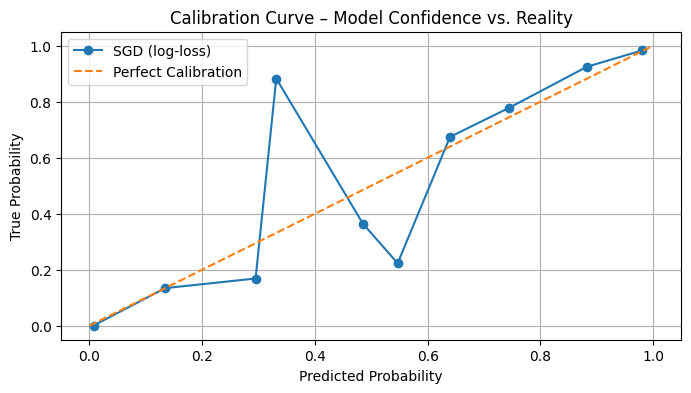

In [ ]:
#Plotting calibration curve
from sklearn.calibration import calibration_curve
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

# Refitting the model
model = SGDClassifier(loss='log_loss', random_state=42)
model.fit(X_train_bin, y_train)

# Getring predicted probabilities for positive class
probs = model.predict_proba(X_test_bin)[:, 1]

# Getting calibration values
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)

# Plotting calibration curve
plt.figure(figsize=(8, 4))
plt.plot(prob_pred, prob_true, marker='o', label='SGD (log-loss)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve – Model Confidence vs. Reality")
plt.legend()
plt.grid(True)
plt.show()


''' 
Calibration Curve – Model Confidence vs. Reality
This graph compares predicted probabilities with the actual outcomes. Key takeaways:
Ideal calibration line (orange): Represents perfect confidence—if the model says "70% confident," the true label should be positive 70% of the time.
Your model (blue line): Shows slight overconfidence in lower probability predictions but trends toward better calibration at higher confidence levels.'''
